## Nested cross-validation
***

Vamos mostrar a aplicação da validação cruzada aninhada. Que deve ser usada quando se quer achar os melhores hiperparâmetros e avaliar o modelo.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (
    KFold,StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV
)
from sklearn import set_config
set_config(display='diagram')

data, target = load_breast_cancer(return_X_y=True)

## Problema: Dado amostras de tumores, usar ML para prever se o tumor é benigno ou maligno --> Problema de Classificação

In [2]:
import pandas as pd

data = pd.DataFrame(data)
target = pd.Series(target).map({0:1, 1:0 })
data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Quantidade de amostras para cada classe: benign e malignant

0    0.627417
1    0.372583
dtype: float64


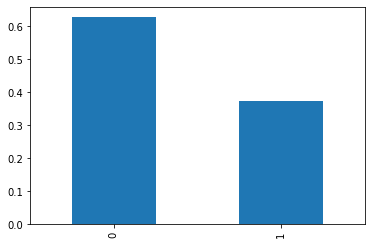

In [5]:
print(target.value_counts(normalize=True))
_ = target.value_counts(normalize=True).plot.bar()

Dividindo o dataset em conjunto de treinamento e teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
                                                        data,
                                                        target,
                                                        test_size=0.3,
                                                        random_state=0
)
X_train.shape, X_test.shape

((398, 30), (171, 30))

In [7]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [8]:
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10], "gamma": [.01, .1]}
model_to_tune = SVC()

Declarando as estratégias "**inner**" e  "**outer**" de validação cruzada

In [9]:
inner_cv = StratifiedKFold(n_splits = 4, shuffle=True, random_state=0)

outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

Utilizando a validação cruzada "**inner**" para fazer a busca de hiperparâmetros (grid search/randomize search)

In [10]:
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2, refit = True, verbose=1)

In [13]:
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

Utilizando a validação cruzada "**outer**" para fazer acessar a performance estatística do melhor modelo, através do score

In [15]:
# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
print(f"A média do score usando a validação cruzada aninhada é: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

A média do score usando a validação cruzada aninhada é: 0.627 +/- 0.023


No exemplo acima o score reportado ao final é mais confiável e a performance estatística deve próxima ao esperado em produção.

In [16]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    inner_cv = StratifiedKFold(n_splits = 4, shuffle=True, random_state=0)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

    # Non_nested parameter search and scoring
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                         cv=inner_cv, n_jobs=2)
    model.fit(X_train, y_train)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    test_score_nested.append(test_score.mean())

In [17]:
import pandas as pd

all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

In [ ]:
all_scores

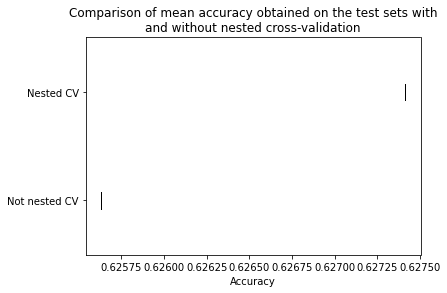

In [18]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")